# 単変量線形回帰の予測区間

In [1]:
import numpy as np

from scipy import stats
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

# 真の回帰直線
* $y = x + 1$

# 観測値
* $x = 0.0, 0.5. 1.0, \dots, 10.0$
* サンプル数: 21
* $Y_i = x_i + 1 + \varepsilon, \varepsilon \sim N(0, 0.5^2)$

In [2]:
# 実験設定
SAMPLE_SIZE = 21
SIGMA = 0.5

In [3]:
# 実験を管理するクラス
class Experiment:
    def __init__(self, random_seed, sigma, sample_size):
        np.random.seed(random_seed)
        
        # 実験設定
        self.sigma = sigma
        self.sample_size = sample_size
        
        # サンプルを生成
        self.x_train = np.array([0.5 * i for i in range(sample_size)])
        self.y_true = self.x_train + 1
        self.y_train = self.y_true + np.random.normal(0.0, sigma, sample_size)
        
        # 回帰係数を算出
        self.x_mean = np.mean(self.x_train)
        self.s_xx = np.sum((self.x_train - self.x_mean) ** 2)

        self.y_mean = np.mean(self.y_train)
        self.s_xy = np.sum((self.x_train - self.x_mean) * (self.y_train - self.y_mean))

        # 回帰係数
        self.coef = self.s_xy / self.s_xx
        self.intercept = self.y_mean - self.coef * self.x_mean
        
        # 不偏標本分散
        s2 = np.sum((self.y_train - self.intercept - self.coef * self.x_train) ** 2) / (sample_size - 2)
        self.s = np.sqrt(s2)
        
        # t分布(自由度N-2)の上側2.5%点
        self.t = stats.t.ppf(1-0.025, df=sample_size-2)

    # サンプルデータを取得する
    def get_sample(self, index):
        return (self.x_train[index], self.y_train[index])
    
    # 予測
    def predict(self, x):
        return self.intercept + self.coef * x
    
    # 真の値
    def calc_true_value(self, x):
        return x + 1
    
    # 95%信頼区間
    def calc_confidence_interval(self, x):
        band = self.t * self.s * np.sqrt(1 / self.sample_size + (x - self.x_mean)**2 / self.s_xx)
        upper_confidence = self.predict(x) + band
        lower_confidence = self.predict(x) - band

        return (lower_confidence, upper_confidence)

    # 95%予測区間
    def calc_prediction_interval(self, x):
        band = self.t * self.s * np.sqrt(1 + 1 / self.sample_size + (x - self.x_mean)**2 / self.s_xx)
        upper_confidence = self.predict(x) + band
        lower_confidence = self.predict(x) - band

        return (lower_confidence, upper_confidence)
    
    # 観測値, 95%予測区間を描画する
    def plot(self):
        # 学習データ
        plt.scatter(self.x_train, self.y_train, color='royalblue', alpha=0.2)

        # 予測区間
        lower_confidence, upper_confidence = self.calc_prediction_interval(self.x_train)
        
        plt.plot(self.x_train, upper_confidence, color='green', linestyle='dashed', label='95% prediction interval')
        plt.plot(self.x_train, lower_confidence, color='green', linestyle='dashed')
        
        x_max = max(self.x_train)
        plt.xlim([0, x_max])
        plt.ylim([0.5, x_max + 1.5])

        plt.legend();
        
    # 観測値, 95%予測区間, 95%信頼区間を描画する
    def plot_with_confidence(self):
        # 学習データ
        plt.scatter(self.x_train, self.y_train, color='royalblue', alpha=0.2)

        # 信頼区間
        lower_confidence, upper_confidence = self.calc_confidence_interval(self.x_train)
        
        plt.plot(self.x_train, upper_confidence, color='royalblue', linestyle='dashed', label='95% confidence interval')
        plt.plot(self.x_train, lower_confidence, color='royalblue', linestyle='dashed')
        
        # 予測区間
        lower_confidence, upper_confidence = self.calc_prediction_interval(self.x_train)
        
        plt.plot(self.x_train, upper_confidence, color='green', linestyle='dashed', label='95% prediction interval')
        plt.plot(self.x_train, lower_confidence, color='green', linestyle='dashed')        
        
        x_max = max(self.x_train)
        plt.xlim([0, x_max])
        plt.ylim([0.5, x_max + 1.5])

        plt.legend();        
        
    # あるxにおける予測区間と観測値を描画する
    def plot_at_x(self, x):
        plt.xlim([x-0.5, x+0.5])
        
        plot_x = np.array([x-0.5, x, x+0.5])
        plot_y = self.predict(plot_x)
        
        # 学習データ
        index = int(2 * x)
        plt.scatter(self.x_train[index], self.y_train[index], color='royalblue', label='sample')

        # 予測区間
        lb, ub = self.calc_prediction_interval(x)
        error = (ub - lb) / 2
        plt.errorbar(plot_x[1], plot_y[1], fmt='o', yerr=error, capsize=5, color='green', label='95% prediction interval')
        
        plt.xlim([x-0.5, x+0.5])

        plt.legend();

# 実験

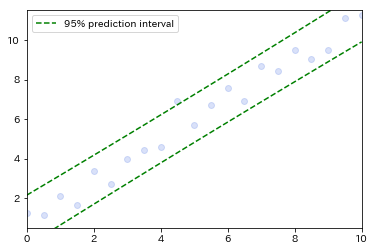

In [4]:
# 観測した標本から95%予測区間を求める
random_seed = 12
experiment = Experiment(random_seed, SIGMA, SAMPLE_SIZE)

experiment.plot()

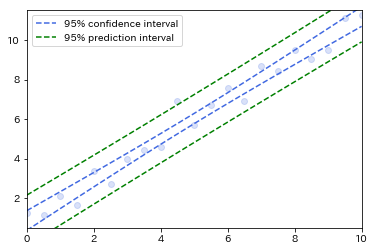

In [5]:
# 観測した標本から95%予測区間, 信頼区間を求める
random_seed = 12
experiment = Experiment(random_seed, SIGMA, SAMPLE_SIZE)

experiment.plot_with_confidence()

## 予測区間に観測値が含まれるケース 

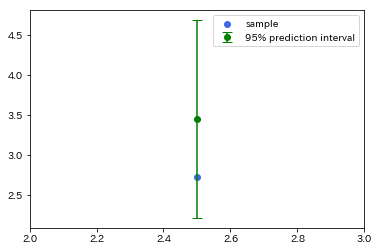

In [6]:
x = 2.5
experiment.plot_at_x(x)

## 予測区間に観測値が含まれないケース 

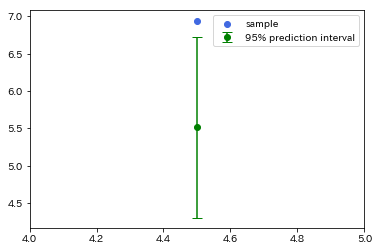

In [7]:
x = 4.5
experiment.plot_at_x(x)

# 実験を1万回繰り返す
* 予測区間に観測値が含まれる割合を計測する

In [8]:
experiment_count = 10000
count = 0

for i in range(experiment_count):
    experiment = Experiment(i, SIGMA, SAMPLE_SIZE)
    
    x = np.random.uniform(0, 10, 1)[0]
    y = x + 1 + np.random.normal(0.0, SIGMA, 1)
    
    lb, ub = experiment.calc_prediction_interval(x)
    
    # 予測区間に観測値が含まれるかチェック
    count += 1 if (lb <= y and y <= ub)  else 0
    
print('予測区間に観測が含まれる割合: {:.1f}%'.format(100 * count / experiment_count))

予測区間に観測が含まれる割合: 94.5%
